<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/videos/Practica_5_1_Inferencia_estadistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 5.1: Inferencia estadística

En este clase vamos a utilizar librerías para resolver numéricamente (utilizando cadenas de Markov) un problema de inferencia estadística. Es decir, contestar preguntas en base a datos (y un modelo).

En particular usaremos dos librerías que debemos conocer más en detalle:
- [Bambi](https://bambinos.github.io/bambi/) (BAyesian Model-Building Interface): para la construcción y calibración de modelos
- [ArviZ](https://python.arviz.org/en/stable/): para la visualización de los resultados de la inferencia y la evaluación de los modelos

Empezaremos importando las librerías clave:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files

# Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

# ArviZ
import arviz as az

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.8 MB/s eta 0:00:00


## Ejemplo: Lluvia centenaria en CABA

Como ejemplo, vamos a seguir el ajuste de un modelo para predecir la máxima lluvia diaria anual en la Ciudad de Buenos Aires.

La pregunta que queremos contestar es:
 ¿Cuál es la lluvia que ocurre una vez cada 100 años? O dicho más correctamente, la lluvia cuyo período de recurrencia es 100 años.

 Para ello, tenemos los datos de lluvia del servicio meteorológico nacional, cuya limpieza pueden pueden explorar en este Google Colab.

In [2]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving PRECIPITACIONES.csv to PRECIPITACIONES.csv


In [3]:
#Se crea un DataFrame
df_lluvia = pd.read_csv(io.BytesIO(uploaded['PRECIPITACIONES.csv']),encoding='ISO-8859-1', sep=';', skiprows=5, header=0)
df_lluvia

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,S/P,S/P,S/P,S/P,S/P,0.4,3.9,25.2,S/P,S/P,S/P,13.3
1,2,S/P,0.1,S/P,S/P,S/P,3.6,2.5,0.2,S/P,S/P,S/P,0.2
2,3,S/P,S/P,S/P,S/P,S/P,1.7,S/P,S/P,S/P,S/P,12.7,S/P
3,4,S/P,S/P,S/P,S/P,S/P,1.5,S/P,S/P,11.2,S/P,S/P,4
4,5,S/P,S/P,S/P,S/P,0.3,S/P,S/P,S/P,S/P,S/P,14.8,S/P
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4511,28,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN
4512,29,S/P,0.1,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN
4513,30,S/P,NaN,<0.1,3,S/P,S/P,S/P,84.1,NaN,NaN,NaN,NaN
4514,31,S/P,NaN,<0.1,NaN,S/P,NaN,S/P,34,NaN,NaN,NaN,NaN


### Limpieza y Ordenamiento

Aquí van a encontrar en forma resumida la limpieza necesaria para generar el dataset de lluvias máximas anuales.

In [4]:
row_keep = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31']

# Guardar solo los datos asociados a Días reales
df_lluvia = df_lluvia.copy()[df_lluvia['Día'].isin(row_keep)].reset_index(drop=True)
df_lluvia

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,S/P,S/P,S/P,S/P,S/P,0.4,3.9,25.2,S/P,S/P,S/P,13.3
1,2,S/P,0.1,S/P,S/P,S/P,3.6,2.5,0.2,S/P,S/P,S/P,0.2
2,3,S/P,S/P,S/P,S/P,S/P,1.7,S/P,S/P,S/P,S/P,12.7,S/P
3,4,S/P,S/P,S/P,S/P,S/P,1.5,S/P,S/P,11.2,S/P,S/P,4
4,5,S/P,S/P,S/P,S/P,0.3,S/P,S/P,S/P,S/P,S/P,14.8,S/P
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3684,27,S/P,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,NaN,NaN,NaN,NaN
3685,28,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN
3686,29,S/P,0.1,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN
3687,30,S/P,NaN,<0.1,3,S/P,S/P,S/P,84.1,NaN,NaN,NaN,NaN


Cada 31 filas cambia el año, así que puedo generar un loop para armar el dataset. Primero, defino el año asociada a cada fila.

In [5]:
# año inicial
ano_ini = 1906

# creo la columna año
df_lluvia['Año'] = 1906

# itero en los las filas de mi dataset para sumar cada "31 dias"
for i in range(df_lluvia.shape[0]):
  df_lluvia.loc[i,'Año'] = int(ano_ini + int(i/31))

df_lluvia

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Año
0,1,S/P,S/P,S/P,S/P,S/P,0.4,3.9,25.2,S/P,S/P,S/P,13.3,1906
1,2,S/P,0.1,S/P,S/P,S/P,3.6,2.5,0.2,S/P,S/P,S/P,0.2,1906
2,3,S/P,S/P,S/P,S/P,S/P,1.7,S/P,S/P,S/P,S/P,12.7,S/P,1906
3,4,S/P,S/P,S/P,S/P,S/P,1.5,S/P,S/P,11.2,S/P,S/P,4,1906
4,5,S/P,S/P,S/P,S/P,0.3,S/P,S/P,S/P,S/P,S/P,14.8,S/P,1906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3684,27,S/P,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,NaN,NaN,NaN,NaN,2024
3685,28,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN,2024
3686,29,S/P,0.1,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN,2024
3687,30,S/P,NaN,<0.1,3,S/P,S/P,S/P,84.1,NaN,NaN,NaN,NaN,2024


Luego, ¡hago un reordenamiento de los datos! Para esto podemos usar la función `melt` de Pandas, que es una forma de mergear valores.

In [6]:
# Armo una matriz de datos
df_lluvia = df_lluvia.copy().melt(id_vars=['Día','Año'],var_name='Mes',
                                   value_name='Precipitación')
df_lluvia

,Día,Año,Mes,Precipitación
0,1,1906,Ene,S/P
1,2,1906,Ene,S/P
2,3,1906,Ene,S/P
3,4,1906,Ene,S/P
4,5,1906,Ene,S/P
...,...,...,...,...
44263,27,2024,Dic,NaN
44264,28,2024,Dic,NaN
44265,29,2024,Dic,NaN
44266,30,2024,Dic,NaN


Ahora podemos trabajar el dataframe un poco más. primero, podemos eliminar los **NaN** (días que no existen, como el 31 de febrero)

In [7]:
df_lluvia = df_lluvia.copy().dropna().reset_index(drop=True)
df_lluvia

,Día,Año,Mes,Precipitación
0,1,1906,Ene,S/P
1,2,1906,Ene,S/P
2,3,1906,Ene,S/P
3,4,1906,Ene,S/P
4,5,1906,Ene,S/P
...,...,...,...,...
43338,27,2023,Dic,6.3
43339,28,2023,Dic,S/P
43340,29,2023,Dic,S/P
43341,30,2023,Dic,S/P


Ahora vamos a generar la fecha y ordenar cronológicamente

In [8]:
#diccionario que relaciona mes con numero
dic_mes = {'Ene':1,'Feb':2,'Mar':3,'Abr':4,'May':5,'Jun':6,'Jul':7,
           'Ago':8,'Sep':9,'Oct':10,'Nov':11,'Dic':12}

# Cambiar columna mes a números
df_lluvia['Mes'] = df_lluvia['Mes'].copy().replace(dic_mes)

# Crear
df_lluvia['Fecha'] = pd.to_datetime(df_lluvia['Año'].astype(str) + '-' +
                                    df_lluvia['Mes'].astype(str) + '-' + df_lluvia['Día'].astype(str),
                                    format='ISO8601')
df_lluvia

/tmp/ipython-input-132213895.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_lluvia['Mes'] = df_lluvia['Mes'].copy().replace(dic_mes)


,Día,Año,Mes,Precipitación,Fecha
0,1,1906,1,S/P,1906-01-01
1,2,1906,1,S/P,1906-01-02
2,3,1906,1,S/P,1906-01-03
3,4,1906,1,S/P,1906-01-04
4,5,1906,1,S/P,1906-01-05
...,...,...,...,...,...
43338,27,2023,12,6.3,2023-12-27
43339,28,2023,12,S/P,2023-12-28
43340,29,2023,12,S/P,2023-12-29
43341,30,2023,12,S/P,2023-12-30


In [9]:
# ordernar cronologicamente los datos
df_lluvia = df_lluvia.copy().sort_values(by='Fecha').reset_index(drop=True)

df_lluvia

,Día,Año,Mes,Precipitación,Fecha
0,1,1906,1,S/P,1906-01-01
1,2,1906,1,S/P,1906-01-02
2,3,1906,1,S/P,1906-01-03
3,4,1906,1,S/P,1906-01-04
4,5,1906,1,S/P,1906-01-05
...,...,...,...,...,...
43338,27,2024,8,S/P,2024-08-27
43339,28,2024,8,S/P,2024-08-28
43340,29,2024,8,S/P,2024-08-29
43341,30,2024,8,84.1,2024-08-30


Me aparecen algunas cosas no deseadas:

- S/P: Sin precipitación (debiera ser 0)
- <0.1: llovió, no significativo (podríamos tomarlo como 0)
- S/D: Sin Dato (habría que explicitamente vaciarlo, como `np.nan`)

In [10]:
# reemplazar S/P y <0.1 por 0
df_lluvia['Precipitación'] = df_lluvia['Precipitación'].copy().replace(['S/P',
                                                                        '<0.1'],0)
# reemplazar S/D por nan
df_lluvia['Precipitación'] = df_lluvia['Precipitación'].copy().replace('S/D',np.nan)

df_lluvia

,Día,Año,Mes,Precipitación,Fecha
0,1,1906,1,0,1906-01-01
1,2,1906,1,0,1906-01-02
2,3,1906,1,0,1906-01-03
3,4,1906,1,0,1906-01-04
4,5,1906,1,0,1906-01-05
...,...,...,...,...,...
43338,27,2024,8,0,2024-08-27
43339,28,2024,8,0,2024-08-28
43340,29,2024,8,0,2024-08-29
43341,30,2024,8,84.1,2024-08-30


Además, habría que setear el tipo de dato correcto a cada columna.

¿Por qué llamo a los datos de día, mes, año como categorías? Porque no voy a trabajar a los datos como una serie de tiempo.

In [11]:
# Modificar los dtypes a los correctos
df_lluvia['Precipitación'] = df_lluvia['Precipitación'].copy().astype('float')
df_lluvia['Año'] = df_lluvia['Año'].copy().astype('category')
df_lluvia['Mes'] = df_lluvia['Mes'].copy().astype('category')
df_lluvia['Día'] = df_lluvia['Día'].copy().astype('category')

df_lluvia.dtypes

,0
Día,category
Año,category
Mes,category
Precipitación,float64
Fecha,datetime64[ns]


Habiendo hecho todo esto, reordenemos las columnas simplemente para claridad (mía), y veamos finalmente qué tenemos.

In [12]:
# Reordenar columnas
df_lluvia = df_lluvia.copy()[['Fecha','Precipitación','Año','Mes','Día']]
df_lluvia

,Fecha,Precipitación,Año,Mes,Día
0,1906-01-01,0.0,1906,1,1
1,1906-01-02,0.0,1906,1,2
2,1906-01-03,0.0,1906,1,3
3,1906-01-04,0.0,1906,1,4
4,1906-01-05,0.0,1906,1,5
...,...,...,...,...,...
43338,2024-08-27,0.0,2024,8,27
43339,2024-08-28,0.0,2024,8,28
43340,2024-08-29,0.0,2024,8,29
43341,2024-08-30,84.1,2024,8,30


In [13]:
# Dataframe de máxima lluvia diaria por año
df_max = df_lluvia.groupby(['Año'],observed=True)[['Precipitación']].agg('max').reset_index()
df_max

,Año,Precipitación
0,1906,80.6
1,1907,76.5
2,1908,73.4
3,1909,52.7
4,1910,51.7
...,...,...
114,2020,79.3
115,2021,72.0
116,2022,101.0
117,2023,69.1


### Resumen

Aquí los datos con los que vamos a trabajar.

In [14]:
# Dataframe de máxima lluvia diaria por año
df_max

,Año,Precipitación
0,1906,80.6
1,1907,76.5
2,1908,73.4
3,1909,52.7
4,1910,51.7
...,...,...
114,2020,79.3
115,2021,72.0
116,2022,101.0
117,2023,69.1


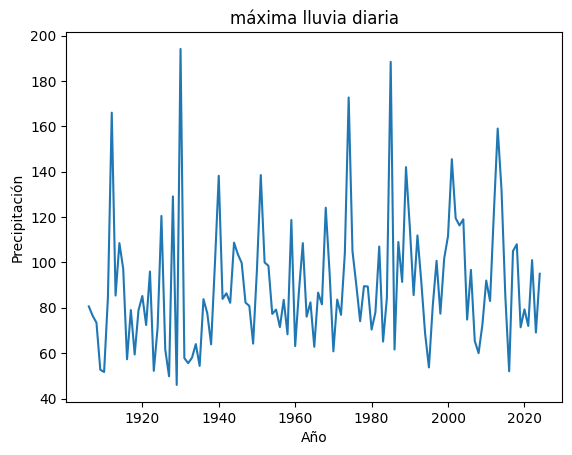

In [15]:
# Grafico de lluvias
sns.lineplot(df_max,x='Año',y='Precipitación').set(title='máxima lluvia diaria')
plt.show()

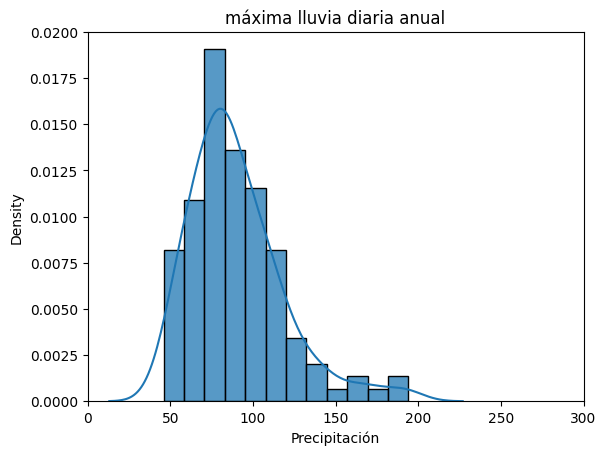

In [16]:
# histograma
sns.histplot(df_max,x='Precipitación',stat='density').set(title='máxima lluvia diaria anual')
sns.kdeplot(df_max,x='Precipitación')
plt.xlim([0,300])
plt.show()

Viendo los datos, ¿qué distribuciones podríamos proponer para la máxima lluvia diaria anual? ¿Quién los pudo haber generado?

### Construcción del modelo en Bambi

Vamos a contestar las pregunta resolviendo la inferencia por Cadenas de Markov, es decir mediante simulación.

#### Ejemplo: El modelo default (una Normal)

La construcción de un modelo de Bambi se hace con la función `Model` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model)). Hay 3 cosas a definir:
- La Fórmula: Es la ecuación que describe al parámetro "valor medio" (o una transformación de este) de la distribución elegida
- La Familia: Qué función de distribución define la verosimilitud
- El Link: Qué transformación aplica a la fórmula (¿Es para el el valor medio? ¿El logaritmo del valor medio? ¿Su inversa?)

Además de lo anterior, es necesario definir las distribuciones a priori. `Bambi` tiene opciones poco informativas si se utiliza el Link por default para una determinada Familia.

La familia por default en `Bambi` es el modelo Normal (`gaussian`). Si no aclaramos nada, usará ese. Cada familia tiene, a su vez, un Link por default. En el caso de la Normal es `identity`. Es decir, que estoy ajustando al valor medio:

Modelo:

$$y \sim Normal(\mu , \sigma)$$

Fórmula para el valor medio (a las constantes, `Bambi` las llama `Intercept`:

$$\mu = Intercept \cdot 1$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(m,s)$$

**NOTA**: La fórmula que se escribe es para el valor medio, pero nada se dijo de `sigma`. Eso es porque `Bambi` lo trata como un término de error a todo parámetro adicional del modelo. En este caso, considera por default:

$$\sigma = Sigma \cdot 1$$

$$p(Sigma)\sim Ht_{v}(m,s)$$

La información anterior respecto a las familias cargadas en `Bambi`y sus `links`por default pueden verla [AQUÍ](https://bambinos.github.io/bambi/notebooks/getting_started.html#families)

A continuación, les dejamos un ejemplo de la carga de datos. Vean que los datos provienen de un dataframe `df_max`, y la formula describe a la columna `Precipitación` del dataframe, que es mi variable `y`.

##### Creación del modelo

ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: random_make_inplace
ERROR:pytensor.graph.rewriting.basic:node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/random/rewriting/basic.py", line 50, in random_make_inplace
    new_outputs = new_op.make_node(*node.inputs).outputs
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^

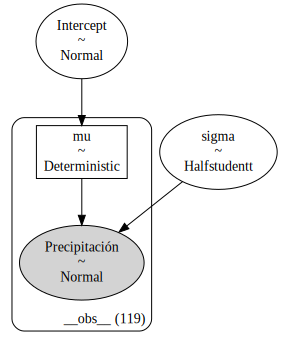

In [17]:
# Construccion del Modelo Normal
model_Norm = bmb.Model('Precipitación~1',data=df_max)
model_Norm.build()

# Visualizacion
model_Norm.graph()

##### Visualización de las prioris

Con el método `plot_priors` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors)) podemos ver la distribución a priori adoptada. Si queremos ver el intervalo de confianza, con `hdi_prob` podemos setearlo. Podrán ver que la priori de `Bambi` suele ser muy poco informativa.

*Nota*: Recuerden que `Intercept`es el valor medio en este caso.

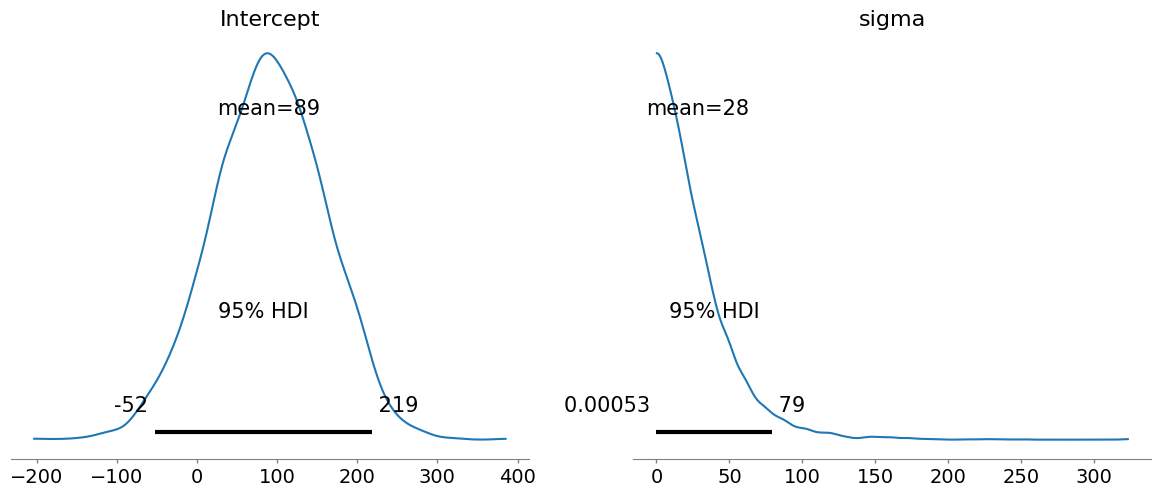

In [18]:
# Graficar distribuciones a priori
model_Norm.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Detallando las distribuciones a priori y el parámetro a ajustar

Ahora vamos a hacer lo mismo pero definiendo nosotros el `link` y adoptando nuestra propia distribución a priori para el `Intercept` ($\mu$). Sabemos que $\mu$ es positivo, así que podría tomarle el logaritmo para que sea un número en todos los reales. Luego, tengo que proponer valores "razonables" para la lluvia máxima diaria. Es mi intuición. Si tengo poco conocimiento, elegiré un rango muy amplio.

Digamos, por ejemplo, que la lluvia máxima promedio espero que esté entre 100 y 200.

Entonces:

Mediana: $\mu = 150$

Desvío: $S = 25$, tal que $2 S = 50$ cubra el intervalo de confianza 90% para $\mu$

El modelo que queremos construir entonces es:

Modelo:

$$y \sim Normal(\mu,\sigma)$$

Fórmula para el valor medio:

$$\mu = Intercept\cdot 1$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(150,25)$$

$$p(Sigma)\sim Exp(1/10)$$

Abajo les dejamos cómo se hace en `Bambi`. Noten que las prioris se cargan como un diccionario, y la importancia de aclarar el `link`.

**NOTA**: Un planteo similar se puede hacer para $\sigma$. Si no quiero introducir mucha información, simplemente elijo algo chato para muchos valores posibles.

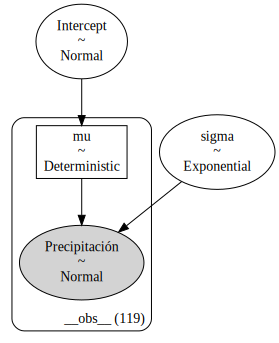

In [19]:
# Construccion del Modelo Normal

# Prioris
prioris = {"Intercept": bmb.Prior("Normal",mu=150,sigma=25),
"sigma":bmb.Prior("Exponential",lam=1/10)}

# Modelo
model_Norm2 = bmb.Model('Precipitación~1',data=df_max,family='gaussian',link='identity',
                    priors=prioris)
model_Norm2.build()

# Visualizacion
model_Norm2.graph()

¡Siempre es importante graficar las prioris para verificar que la distribución a priori resultó la que ustedes querían! Es nuy común que `Bambi` no la tome, por ejemplo, por nombrar mal el parámetro en el diccionario. O que los valores en la priori no sean los que uno realmente quería introducir al problema.

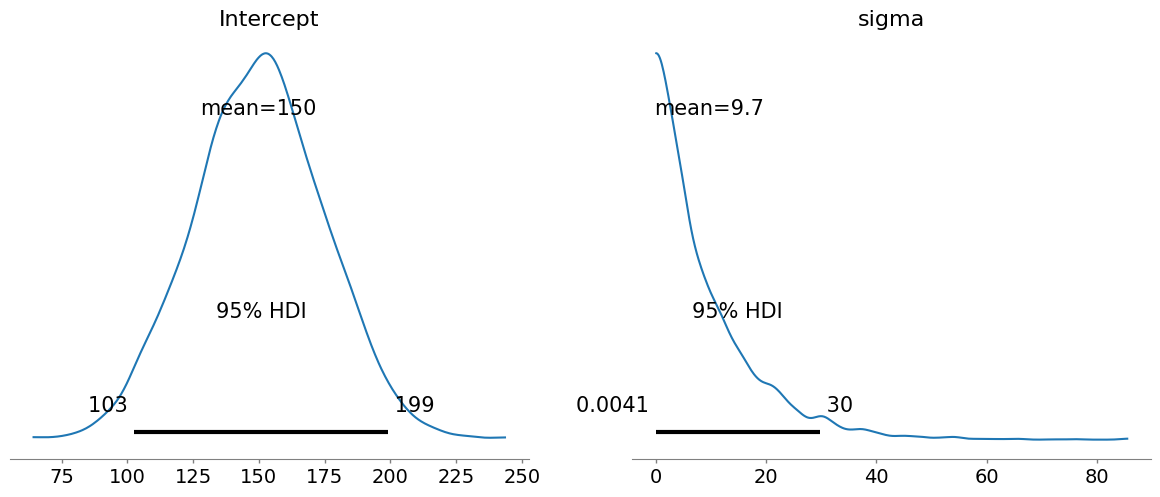

In [20]:
# Graficar prioris
model_Norm2.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Un modelo Gamma

Las familias de `Bambi` me permiten elegir de una amplia variedad de modelos, por ejemplo, una gamma. Usarlo es sencillo, simplemente hay que prestar atención en la documentación para entender qué significa cada parámetro. En este caso, para el parámetro principal nos queda:

- Modelo

$$y \sim Gamma(m,\alpha)$$

- Fórmula

$$1/m = Intercept \cdot 1$$

- Prioris

$$p(Intercept) \sim ``Bambi"$$
$$p(\beta) \sim ``Bambi"$$

¡Y lo único que tengo que hacer es cambiar el `family` al construir el modelo!

In [21]:
# Construccion del Modelo Gamma
model_Gamma = bmb.Model('Precipitación~1',data=df_max,family='gamma')
model_Gamma.build()

# Visualizacion
#model_Gamma.graph()

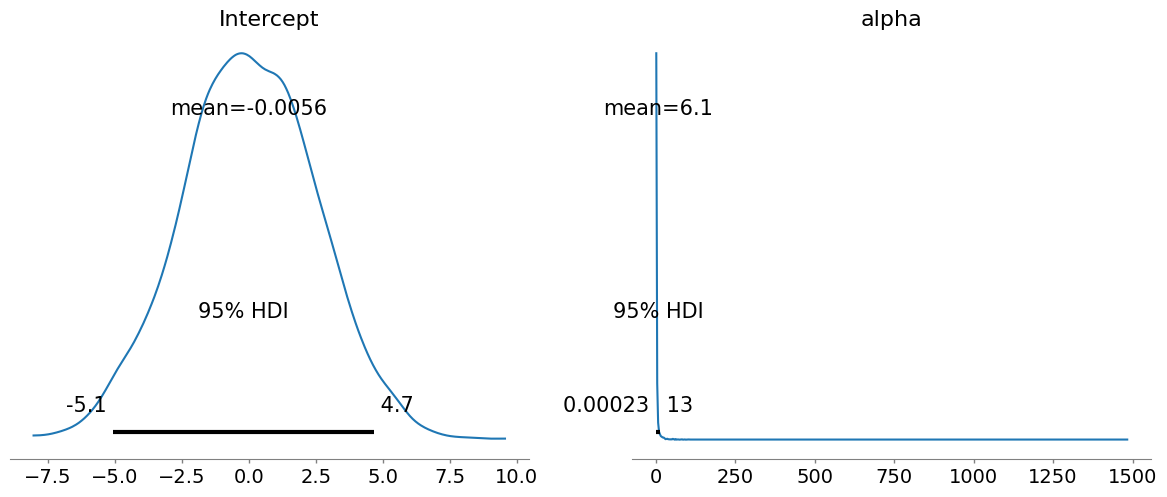

In [22]:
# Graficar prioris
model_Gamma.plot_priors(hdi_prob=0.95)
plt.show()

### Realizar la inferencia y evaluar convergencia

El siguiente paso, si vemos bien las prioris que elegimos, es proceder con la inferencia para obtener las distribuciones posteriores. Para ello usamos el método `fit()` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.fit)). Los variables clave que permite el método son:

- Draws: La cantidad de simulaciones por cadena
- Chains: La cantidad de cadenas (generalmente se hace una por núcleo disponible ya que permite simular en paralelo y ahorrar tiempo. Lo recomendable es hacer al menos 4 cadenas). El total de simulaciones con 8000 puede estar bien para algo sencillo.
- Random_seed: Valor que me permite generar consistencia/manipular la aleatoriedad de las simulaciones.

Esto devuelve un `Inference Data` (veremos más adelante qué tiene dentro) con simulaciones. Lo importante es revisar que la inferencia haya salido bien. Para ello hay que mirar.

- Que no haya divergencias (especialmente en modelos sencillos. Pueden aceptarse algunas pocas en modelos complejos con muchos parámetros)
- Que las cadenas sean un ruido blanco sin tendencias o autocorrelación (que sean independientes)
- Que las cadenas hayan convergido y tenga similar variabilidad.

Esto puede hacerse en forma visual mediante la función `plot_trace` [LINK](https://python.arviz.org/en/latest/api/generated/arviz.plot_trace.html). La variable `compact=False` lo que hace es separar en ciertos casos los distintos parámetros simulados para mayor claridad en vez de agruparlos en un mismo gráfico. Debieran ver que las distribuciones posteriores de cada cadena se parezcan entre sí, y que las simulaciones parezcan un ruido blanco superpuesto horizontal.

Luego, el otro dato clave es el Coeficiente $R$, que compara la variable dentro de una misma cadena con la variabilidad entre cadenas. Este número debiera ser **muy** cercano a 1 (1.03 como mucho). ArviZ lo calcula por ustedes con la función `summary` [LINK](https://python.arviz.org/en/latest/api/generated/arviz.summary.html).

Output()

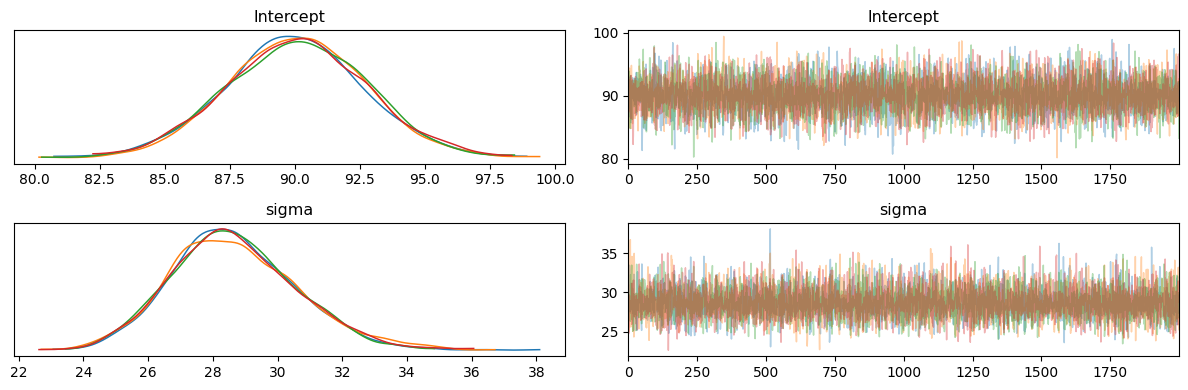

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,90.053,2.670,84.729,95.246,0.029,0.029,8420.0,6052.0,1.0
sigma,28.660,1.933,24.922,32.391,0.022,0.024,8116.0,5197.0,1.0


In [23]:
# Hacer inferencia por MCMC
results_Norm = model_Norm.fit(draws=2000,chains=4)

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_Norm, compact=False)
plt.tight_layout()
plt.show()

# Numerico
az.summary(results_Norm,hdi_prob=0.95)

Como dijimos antes, la inferencia devuelve un `Inference Data`. Abajo pueden ver lo que tiene (¡es clickeable!)

- En `posterior` van a encontrar las simulaciones de la distribución posterior de los parámetros. Es una matriz de (#cadenas,#simulaciones). Después vemos como extraerla como un Numpy Array
- En `observed_data` van a encontrar los datos utilizados para la inferencia/predicción. Es una matriz de (#obs), también extraible como Numpy Array.

In [24]:
results_Norm

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Distribución posterior

Si todo esta bien, ya podemos empezar a informar resultados de nuestra inferencia. La función `plot_posterior` (muy útil y versátil, [LINK](https://python.arviz.org/en/latest/api/generated/arviz.plot_posterior.html)) permite graficar, entre otras cosas la distribución posterior de los parámetros si le entregamos nuestro Inference Data. con `var_names` pueden definir como lista los parámetros que quieren graficar, y con `hdi_prob` el intervalo de confianza. La función devuelve un gráfico que incluye también aspectos claves de la distribución.

Esa misma información la pueden encontrar en forma de tabla con la función `summary` que vimos antes, que acepta las mismas variables para seleccionar parámetros e intervalos de confianza

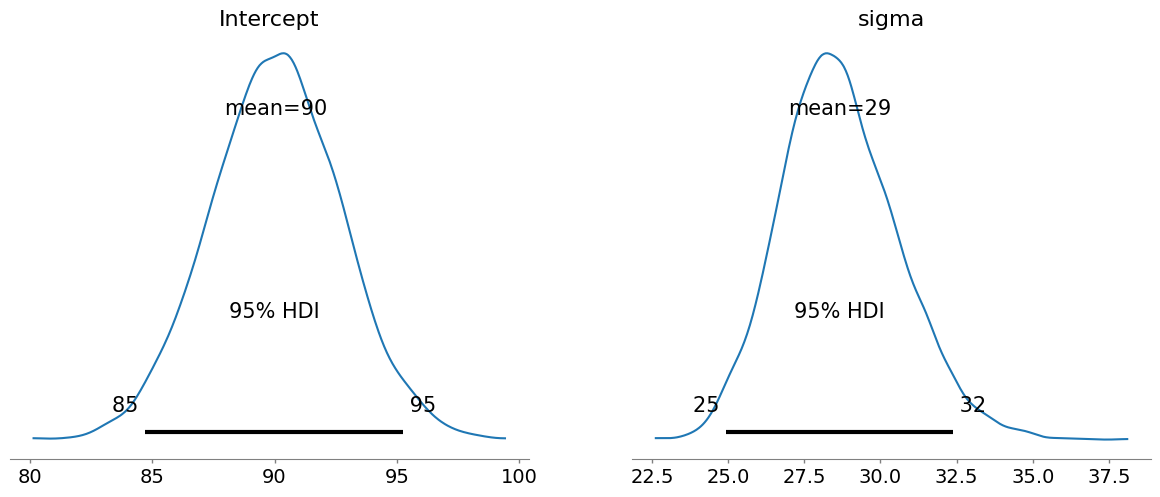

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,90.053,2.670,84.729,95.246,0.029,0.029,8420.0,6052.0,1.0
sigma,28.660,1.933,24.922,32.391,0.022,0.024,8116.0,5197.0,1.0


In [25]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_Norm,hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_Norm,hdi_prob=0.95)

Como nota, es posible extraer los límites del intervalo de confianza con la función `hdi` de ArviZ ([LINK](https://python.arviz.org/en/latest/api/generated/arviz.hdi.html)). Notarán que lo hice extrayendo los datos del Inference Data como matriz (ahora lo vemos bien como se hace). ¡Esto significa que la función sirve para cualquier vector de datos simulados!

In [26]:
IC05,IC95 = az.hdi(np.ravel(results_Norm.posterior['Intercept'].values), hdi_prob=0.90)
print('Intervalo de confianza del 5%:',IC05)
print('Intervalo de confianza del 95%:',IC95)

Intervalo de confianza del 5%: 85.4277967239113
Intervalo de confianza del 95%: 94.2121839371108


### Distribución posterior predictiva (nuevas simulaciones)

Si quiero obtener nuevas simulaciones de cosas que no observé (años futuros en este caso), puedo hacerlo con el método `predict` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict)). `kind='response'` indica que quiero simular no solo los parámetros del modelo sino también nuevos datos (si quisiera simular sólo los parámetros del modelo se haría con `kind='response_params'`, que es el default). Con `inplace=True` indico que quiero sobreescribir el Inference Data agregando las nuevas simulaciones, sin tener que guardarlo en una nueva variable.

Luego, la función `plot_ppc` permite gráficar las réplicas de mi ensayo, la posterior predictiva y comparar contra el histograma de los datos. Ya pueden empezar a ver qué tan probable es que su modelo genere algo parecido a sus datos.

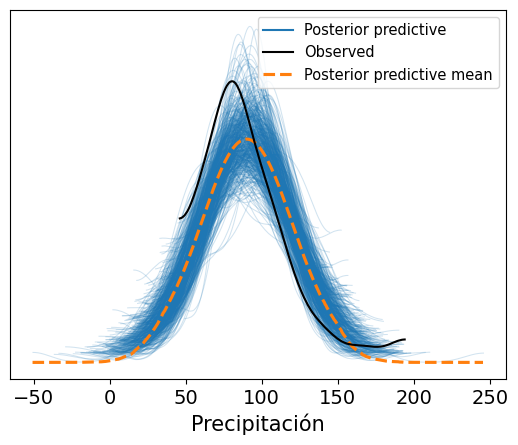

In [27]:
# Nuevas simulaciones (lo guarda en la misma variable results_norm de antes con inplace=True)
model_Norm.predict(results_Norm, kind="response",inplace=True)

# Grafico
az.plot_ppc(results_Norm,num_pp_samples=500)
plt.show()

### Accediendo a las simulaciones

Como dijimos antes, el resultado de la inferencia y la predicción es un Inference Data. Verán que luego de predecir se agregó una nueva sección de nombre `posterior_predictive`. Allí van a encontrar las simulaciones de los datos/mi variable de interés, en tamaño (#cadenas,#simulaciones,#obs). Es decir, genera muchas réplicas de mi ensayo con el tamaño original de mis datos.

Además, en la sección `posterior` se agregó también el cálculo de `mu`, lo cual es muy útil dado que no siempre es directamente el parámetro a calibrar.

In [28]:
results_Norm

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Estsa simulaciones pueden extraerse como Numpy Arrays para su manipulación o calculos (valores medios, cuantiles, cálculos de probabilidad, etc.

Abajo les dejamos como hacerlo para la posterior...

In [29]:
results_Norm.posterior['Intercept'].values

array([[87.73796517, 89.88834928, 92.89705445, ..., 89.22277813,
        92.17390425, 90.3636376 ],
       [91.05672687, 90.11817121, 89.39019707, ..., 90.94556745,
        91.36686105, 92.66472481],
       [89.89774506, 89.89774506, 88.04772096, ..., 87.97609083,
        92.19235691, 83.22619392],
       [90.48839068, 92.3215113 , 87.37434608, ..., 94.77636203,
        96.61053121, 89.03350696]])

In [30]:
results_Norm.posterior['sigma'].values

array([[27.85705457, 28.61268417, 27.61766071, ..., 27.35183541,
        29.44599714, 29.61703345],
       [31.89870473, 32.89046608, 24.93528575, ..., 33.20371008,
        25.84412949, 25.22877009],
       [29.46972007, 29.46972007, 29.77032423, ..., 28.4814884 ,
        29.94744248, 29.55405933],
       [28.21025919, 31.00733163, 24.73758456, ..., 29.30783982,
        28.72477065, 29.3869646 ]])

Para la posterior predictiva...

In [31]:
results_Norm.posterior_predictive['Precipitación'].values

array([[[154.49951375,  65.44166934, 101.23718287, ...,  75.68299292,
          62.86510077,  54.43391151],
        [109.13775177,  69.9050935 , 117.41114855, ..., 157.12497292,
          78.64874068,  76.97680563],
        [ 97.0660077 ,  61.45445026,  57.24440535, ..., 115.52330094,
         171.43352448, 104.95034147],
        ...,
        [121.71937445,  98.52467979,  99.16264874, ...,  90.97848762,
          53.06213671,  30.85769015],
        [ 95.1669279 , 122.0868857 ,  77.19441286, ...,  47.93015568,
         104.94721044,  82.05387925],
        [ 96.68479762,  80.20801901, 112.35591396, ...,  78.43536505,
         100.13948693,  97.54716873]],

       [[ 74.44903003,  85.95327523, 109.69624103, ..., 135.6346473 ,
         102.12408715,  67.48515505],
        [122.18924933, 128.52786618,  83.43997152, ...,  97.8038924 ,
         122.83866559,  25.39085902],
        [ 70.23054985,  95.04295357, 129.74532564, ..., 109.52219718,
         110.34495899,  72.00490485],
        ...,


Y para los datos observados que se usaron.

In [32]:
results_Norm.observed_data['Precipitación'].values

array([ 80.6,  76.5,  73.4,  52.7,  51.7,  84.6, 166. ,  85.4, 108.5,
        97.2,  57.3,  79. ,  59.4,  78.9,  85.2,  72.4,  96. ,  52.2,
        71.2, 120.5,  61.6,  49.8, 129.1,  46. , 194.1,  57.8,  55.6,
        58. ,  64. ,  54.4,  83.8,  77.6,  63.9,  99.4, 138.2,  83.9,
        86.4,  82.2, 108.7, 103.6,  99.8,  82.3,  80.8,  64.2,  97. ,
       138.5, 100. ,  98.5,  77.3,  79.2,  71.5,  83.5,  68.3, 118.7,
        63.1,  87.6, 108.5,  76.1,  82.4,  62.8,  86.7,  81.5, 124.1,
        95.6,  60.8,  83.6,  76.9, 104.2, 172.7, 104.9,  90. ,  74.1,
        89.5,  89.4,  70.4,  78. , 107. ,  65.1,  84.3, 188.4,  61.6,
       109. ,  91.4, 142. , 115.6,  85.6, 111.9,  91.6,  68.7,  53.7,
        80.7, 100.7,  77.4, 101.8, 111.6, 145.5, 119.5, 116.3, 119. ,
        74.8,  96.7,  65.4,  60. ,  72.6,  92. ,  83. , 122. , 159. ,
       132. ,  85. ,  52. , 105. , 108. ,  71.4,  79.3,  72. , 101. ,
        69.1,  95. ])

### Uso del modelo (contestar preguntas)

Todo esto lo hicimos con una razón: contestar nuestra pregunta original.

- ¿Cuál es la lluvia que ocurre una vez (se supera) cada 100 años? O dicho más correctamente, la lluvia cuyo período de recurrencia es 100 años.

Extrayendo los datos como vimos antes, ¡ahora simplemente es un problema de conteo!

Recordemos que el período de retorno $T(x)$ es el tiempo promedio $T$ entre eventos que superan determinado valor de la variable $x$:

$$T(x) = \frac{1}{1-p(X\leq x)}$$

lo que considera que el tiempo promedio es la inversa de la probabilidad de excedencia.

La lluvia centenaria es de: 157.0 mm


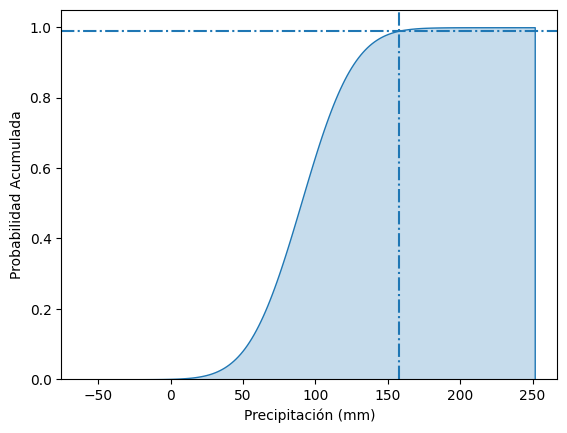

In [33]:
# Accedo a los datos
Simul = results_Norm.posterior_predictive['Precipitación'].values

# Probabilidad de ocurrencia de lluvia menor a la milenaria en un año
P100 = 1-1/100

# Cuantil de lluvia asociado a esa probabilidad
Lluvia = np.quantile(np.ravel(Simul),P100)
print('La lluvia centenaria es de:',round(Lluvia,0),'mm')

sns.kdeplot(np.ravel(Simul),cumulative=True,fill=True)
plt.axhline(P100,ls='-.')
plt.axvline(Lluvia,ls='-.')
plt.xlabel('Precipitación (mm)')
plt.ylabel('Probabilidad Acumulada')
plt.show()

### ¿Qué pasaba si usaba otro modelo para contestar?

Como verán, la respuesta a mi pregunta no depende sólo de mis datos, sino también del modelo que yo elijo para explicar mis datos. Por lo tanto, jueguemos un poco y contestemos la pregunta usando ahora el modelo Gamma.

Recordemos cómo era:

In [34]:
# Visualizar
#model_Gamma.graph()

#### Construcción Rápida

Luego de chequear las distribuciones a priori, el primer paso es hacer la inferencia y verificar la convergencia.

Output()

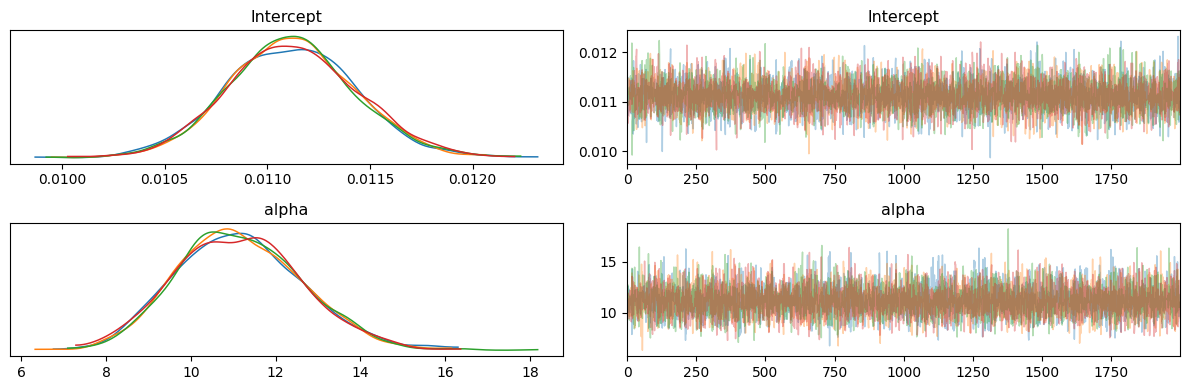

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.011,0.000,0.010,0.012,0.000,0.000,7585.0,5541.0,1.0
alpha,11.153,1.473,8.394,14.048,0.016,0.017,8390.0,5742.0,1.0


In [35]:
# Hacer inferencia por MCMC
results_Gamma = model_Gamma.fit(draws=2000,chains=4)

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_Gamma, compact=False)
plt.tight_layout()
plt.show()

# Numerico
az.summary(results_Gamma,hdi_prob=0.95)

Luego, miro la distribución posterior de los parámetros:

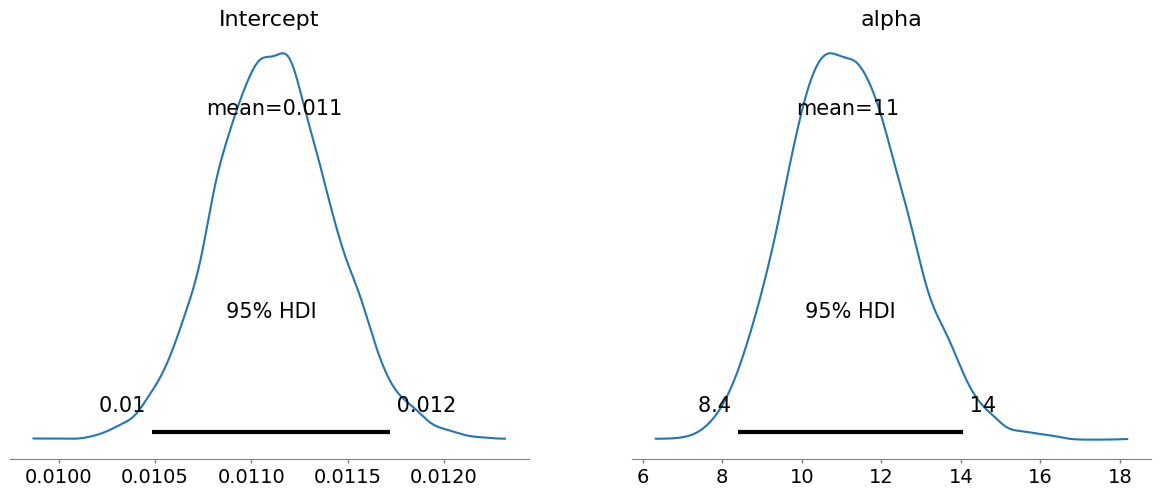

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.011,0.000,0.010,0.012,0.000,0.000,7585.0,5541.0,1.0
alpha,11.153,1.473,8.394,14.048,0.016,0.017,8390.0,5742.0,1.0


In [36]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_Gamma,hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_Gamma,hdi_prob=0.95)

Ven que no devuelve el valor medio, sino el parámetro `Intercept`. Para ver el valor medio, debiera pedirle que lo "prediga" o hacer la cuenta manualmente.

Y, luego, puedo generar nuevas simulaciones de lluvia (posterior predictiva) y chequear el modelo.

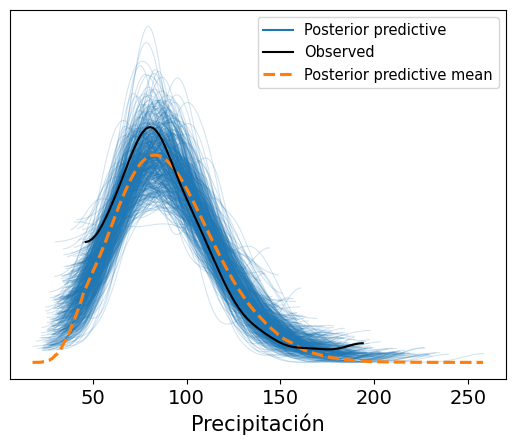

In [37]:
# Nuevas simulaciones (lo guarda en la misma variable results_ln de antes con inplace=True)
model_Gamma.predict(results_Gamma, kind="response",inplace=True)

# Grafico
az.plot_ppc(results_Gamma,num_pp_samples=500)
plt.show()

¿Qué modelo parece ajustar mejor?

#### Uso del modelo (contestar preguntas)

Todo esto lo hicimos con una razón: contestar nuestra pregunta original.

- ¿Cuál es la lluvia que ocurre una vez (se supera) cada 100 años? O dicho más correctamente, la lluvia cuyo período de recurrencia es 100 años.

¿Cuánto dará si adopto el modelo Gamma?

La lluvia centenaria es de: 166.0 mm


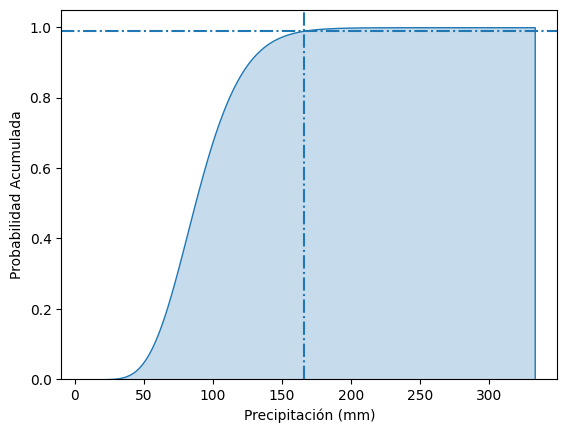

In [38]:
# Accedo a los datos
Simul = results_Gamma.posterior_predictive['Precipitación'].values

# Probabilidad de ocurrencia de lluvia menor a la milenaria en un año
P100 = 1-1/100

# Cuantil de lluvia asociado a esa probabilidad
Lluvia = np.quantile(np.ravel(Simul),P100)
print('La lluvia centenaria es de:',round(Lluvia,0),'mm')

sns.kdeplot(np.ravel(Simul),cumulative=True,fill=True)
plt.axhline(P100,ls='-.')
plt.axvline(Lluvia,ls='-.')
plt.xlabel('Precipitación (mm)')
plt.ylabel('Probabilidad Acumulada')
plt.show()

¡5% más! Así que es importante definir qué modelo se ajusta mejor a los datos antes de avanzar.